Introduction
=======

This notebook presents neural network classifition models apply toward hand-written images(MNIST dataset).
We start with from simple model using softmax to the recent convolutional neural network.



In [1]:
%matplotlib inline
import os 
import theano
from theano import tensor as T
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from IPython.display import SVG
import theano.d3viz as d3v


In [2]:
""" 
Load and devide MNIST data set into train, test sets
X is image, and Y is its label.
The image size is 28*28, and we flatten it to a 784-dim vector 
"""

def one_hot(x, n):
    """
    The label is represented in onehot vector. A onehot vector is 
    a vector which is 0 in most dimensions, and 1 in a single 
    dimension. In this case, the nth digit will be represented as 
    a vector which is 1 in the nth dimensions. 
    For example, 0 would be [1,0,0,0,0,0,0,0,0,0,0]. 
    """
    if type(x) == list:
        x = np.array(x)       
    x = x.flatten()
    o_h = np.zeros((len(x), n))
    o_h[np.arange(len(x)), x] = 1
    return o_h

def mnist(ntrain=60000, ntest=10000, onehot=True):
   
    data_dir = 'datasets\\mnist'
    
    fd = open(os.path.join(data_dir, 'train-images.idx3-ubyte'))
    loaded = np.fromfile(file=fd, dtype=np.uint8)
    trX = loaded[16:].reshape((60000, 28*28)).astype(float)

    fd = open(os.path.join(data_dir, 'train-labels.idx1-ubyte'))
    loaded = np.fromfile(file=fd, dtype=np.uint8)
    trY = loaded[8:].reshape((60000))

    fd = open(os.path.join(data_dir, 't10k-images.idx3-ubyte'))
    loaded = np.fromfile(file=fd, dtype=np.uint8)
    teX = loaded[16:].reshape((10000, 28*28)).astype(float)

    fd = open(os.path.join(data_dir, 't10k-labels.idx1-ubyte'))
    loaded = np.fromfile(file=fd, dtype=np.uint8)
    teY = loaded[8:].reshape((10000))

    trX = trX/255.
    teX = teX/255.

    trX = trX[:ntrain]
    trY = trY[:ntrain]

    teX = teX[:ntest]
    teY = teY[:ntest]
    
    if onehot:
        trY = one_hot(trY, 10)
        teY = one_hot(teY, 10)
    else:
        trY = np.asarray(trY)
        teY = np.asarray(teY)

    return trX,teX,trY,teY

trX, teX, trY, teY = mnist(onehot=True)  #Loading data matrices

In [4]:
def floatX(X):
    """ Conver to correct dtype """
    return np.asarray(X, dtype=theano.config.floatX)

def init_weights(shape, var_name):
    """ initalize model parameters """
    return theano.shared(floatX(np.random.randn(*shape) * 0.01), name=var_name)

def init_bias(n_out, var_name):
    """ initialize bias weight as a vector of 0s"""
    return theano.shared(floatX(np.zeros((n_out,))), name=var_name)

def model(X, w, b):
    """Logistic regresion in matrix format y = softmax(X.w + b)
    This neural net has no hidden layer.
    """
    return T.nnet.softmax(T.dot(X, w) + b)


In [5]:
X = T.fmatrix("X")  # matrix types variables
Y = T.fmatrix("Y")

w = init_weights((784, 10), 'w')  # initalize weights matrix
b = init_bias(10, 'b') 

In [6]:
py_x = model(X, w, b)  # p(y|x): probability of label given the input
y_pred = T.argmax(py_x, axis=1)  # probality outputs and max predictions

In order to train our model, we need to define what it means for the model 
to be good. Well, actually, in machine learning we typically define what it 
means for a model to be bad, called the cost or loss, and then try to minimize 
how bad it is. But the two are equivalent.

One very common, very nice cost function is "cross-entropy." Surprisingly, 
cross-entropy arises from thinking about information compressing codes in 
information theory but it winds up being an important idea in lots of areas, 
from gambling to machine learning. It's defined:

\begin{equation*}
H_Y(p(y|x)) = - \sum_i y_i * log(p(y|{x_i}))
\end{equation*}

where Y os the true distribution (the one-hot vector we'll input) $p(y|x)$ is our predicted probability distribution
In some rough sense, the cross-entropy is measuring how inefficient our 
predictions are for describing the truth.   

In [ ]:
cost = T.mean(T.nnet.categorical_crossentropy(py_x, Y))

In [8]:
gradient_w = T.grad(cost=cost, wrt=w)  # Compute gradient for weights w
gradient_b = T.grad(cost=cost, wrt=b)  # Compute gradient for bias b

update = [(w, w - gradient_w * 0.05), 
          (b, b - gradient_b * 0.05)]  # Weight update with gradient descent

# compile train function
train = theano.function(inputs=[X, Y], 
                        outputs=cost, 
                        updates=update, 
                        allow_input_downcast=True)

# compile prediction function
predict = theano.function(inputs=[X], 
                          outputs=y_pred, 
                          allow_input_downcast=True)

In [9]:
# run training with 100 iteration and on mini-batches of 128 examples
for i in range(100):
    for start, end in zip(range(0, len(trX), 128), range(128, len(trX), 128)):
        cost = train(trX[start:end], trY[start:end])
    print i, np.mean(np.argmax(teY, axis=1) == predict(teX))
        

0 0.8868
1 0.8996
2 0.9057
3 0.9095
4 0.9118
5 0.9131
6 0.9157
7 0.916
8 0.9162
9 0.9173
10 0.9179
11 0.9178
12 0.9186
13 0.9188
14 0.9192
15 0.9197
16 0.9199
17 0.9202
18 0.9206
19 0.9208
20 0.9207
21 0.9211
22 0.9215
23 0.9218
24 0.9221
25 0.922
26 0.9221
27 0.9221
28 0.9223
29 0.9225
30 0.9222
31 0.9223
32 0.922
33 0.9217
34 0.9217
35 0.9219
36 0.9223
37 0.9224
38 0.9224
39 0.9228
40 0.9231
41 0.923
42 0.923
43 0.923
44 0.923
45 0.9232
46 0.9231
47 0.9232
48 0.9232
49 0.9229
50 0.9227
51 0.9228
52 0.9232
53 0.9233
54 0.9235
55 0.9234
56 0.9235
57 0.9235
58 0.9236
59 0.9235
60 0.9235
61 0.9235
62 0.9235
63 0.9236
64 0.9237
65 0.9237
66 0.9236
67 0.9237
68 0.9236
69 0.9237
70 0.9238
71 0.9237
72 0.9237
73 0.9237
74 0.9238
75 0.9239
76 0.924
77 0.9241
78 0.9242
79 0.9243
80 0.9243
81 0.9244
82 0.9244
83 0.9244
84 0.9245
85 0.9246
86 0.9245
87 0.9247
88 0.9247
89 0.9246
90 0.9248
91 0.9248
92 0.9248
93 0.9249
94 0.925
95 0.9249
96 0.9249
97 0.925
98 0.9251
99 0.9252


In [ ]:
def analyze_net(w_o, img_dim):    
    """ What does the softmax learn? """
    matplotlib.rc('xtick', labelsize=30) 
    matplotlib.rc('ytick', labelsize=30)   

    a = np.array(w_o.get_value())  
    fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(40, 15))
    for i, ax in enumerate(axes.flat):
        ax.set_title(str(i), fontsize=50)
        im = ax.imshow(a[:,i].reshape(img_dim, img_dim), interpolation='none')

    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
    fig.colorbar(im, cax=cbar_ax)
    plt.show()
    #plt.pause(0.1)

Softmax [id A] ''   
 |Elemwise{add,no_inplace} [id B] ''   
   |dot [id C] ''   
   | |X [id D]
   | |w [id E]
   |DimShuffle{x,0} [id F] ''   
     |b [id G]


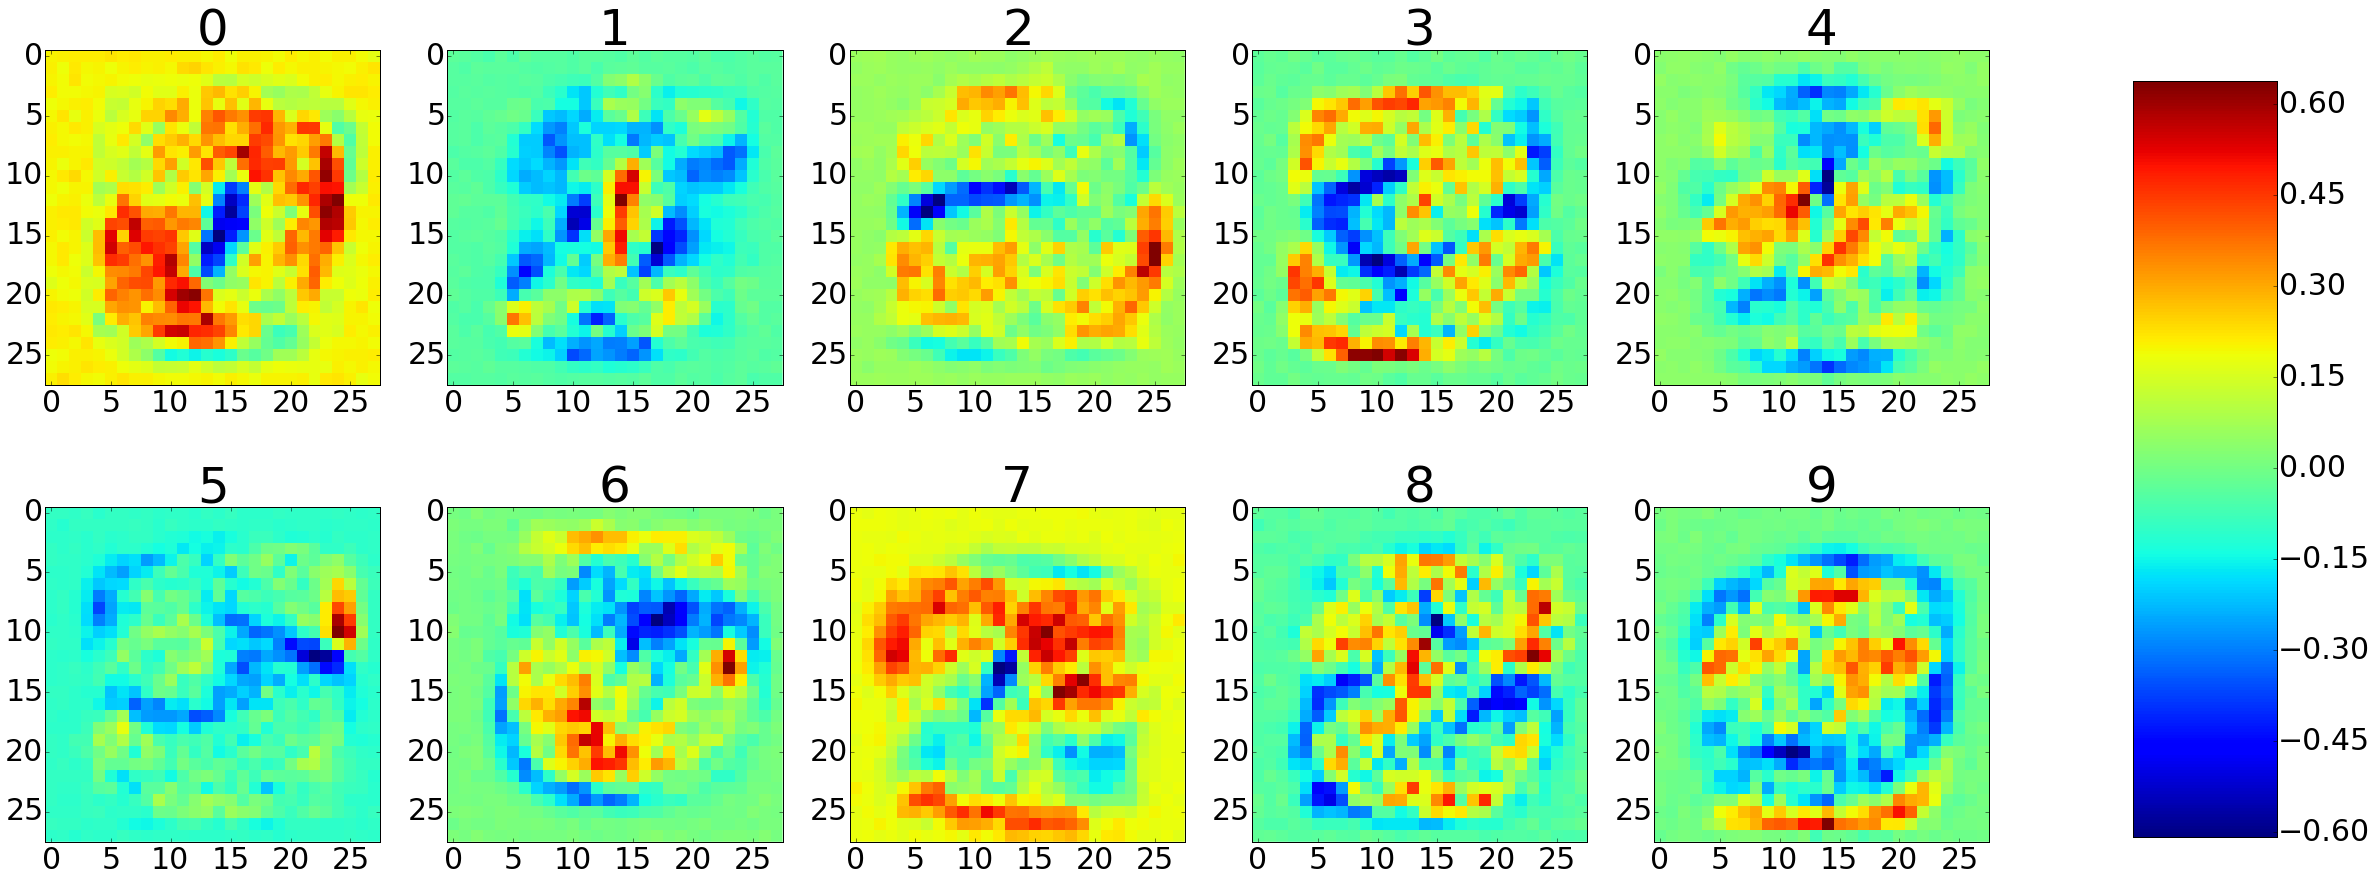

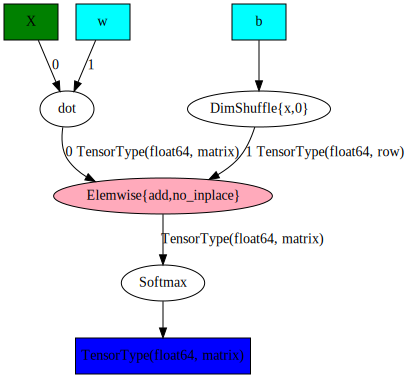

In [11]:
""" What does the softmax learn? """
theano.printing.debugprint(py_x)
analyze_net(w, 28)
d3v.d3viz(predict, 'test-output/NoHiddenLayer.html')
SVG(theano.printing.pydotprint(py_x, var_with_name_simple=True, return_image=True, format='svg')) # need to install GraphViz & pydot

In [12]:
""" A feed forward neural network with 1 hidden layer
The NN architecture is 784 -> 625 -> 10
We change model() and use Schotastic Gradient Descent to update weight()
"""

def sgd(cost, params, lr=0.05):
    """generalize to compute gradien descent on all model parameters"""
    grads = T.grad(cost=cost, wrt=params)
    updates = []
    for p, g in zip(params, grads):
        updates.append([p, p - g * lr])
    return updates

def model(X, w_h, b_h, w_o, b_o):
    # hidden layer use sigmod as its activation function
    h = T.nnet.sigmoid(T.dot(X, w_h) + b_h)
        
    #output layer still uses softmax
    pyx = T.nnet.softmax(T.dot(h, w_o) + b_o)
    return pyx


In [13]:
w_h = init_weights((784, 625), 'w_h')  # initialize weights for hidden layer
b_h = init_bias(625, 'b_h') 
w_o = init_weights((625, 10), 'w_o')
b_o = init_bias(10, 'b_o') 
b_o = init_bias(10) 

py_x = model(X, w_h, b_h, w_o, b_o)
y_x = T.argmax(py_x, axis=1)

cost = T.mean(T.nnet.categorical_crossentropy(py_x, Y))
params = [w_h, b_h, w_o, b_o]  # the NN has 1 hidden layer and 1 output layer with bias vector
updates = sgd(cost, params) # use SGD as it update function

train = theano.function(inputs=[X, Y], outputs=cost, updates=updates, allow_input_downcast=True)
predict = theano.function(inputs=[X], outputs=y_x, allow_input_downcast=True)

matplotlib.rc('xtick', labelsize=30) 
matplotlib.rc('ytick', labelsize=30)

for i in range(50):
    for start, end in zip(range(0, len(trX), 128), range(128, len(trX), 128)):
        cost = train(trX[start:end], trY[start:end])
    print i, np.mean(np.argmax(teY, axis=1) == predict(teX))          

0 0.6996
1 0.8273
2 0.8674
3 0.8828
4 0.8893
5 0.8951
6 0.8982
7 0.9012
8 0.9041
9 0.9067
10 0.9091
11 0.9113
12 0.9132
13 0.9132
14 0.9139
15 0.9148
16 0.9162
17 0.9172
18 0.9175
19 0.9183
20 0.9187
21 0.9191
22 0.9187
23 0.9196
24 0.9205
25 0.9207
26 0.9208
27 0.9216
28 0.922
29 0.9225
30 0.9233
31 0.9239
32 0.9239
33 0.9246
34 0.925
35 0.925
36 0.9253
37 0.9261
38 0.9267
39 0.9272
40 0.9275
41 0.9279
42 0.9282
43 0.9288
44 0.9299
45 0.9306
46 0.9309
47 0.9317
48 0.9325
49 0.9333


Softmax [id A] ''   
 |Elemwise{add,no_inplace} [id B] ''   
   |dot [id C] ''   
   | |sigmoid [id D] ''   
   | | |Elemwise{add,no_inplace} [id E] ''   
   | |   |dot [id F] ''   
   | |   | |X [id G]
   | |   | |w_h [id H]
   | |   |DimShuffle{x,0} [id I] ''   
   | |     |b_h [id J]
   | |w_o [id K]
   |DimShuffle{x,0} [id L] ''   
     |b_o [id M]


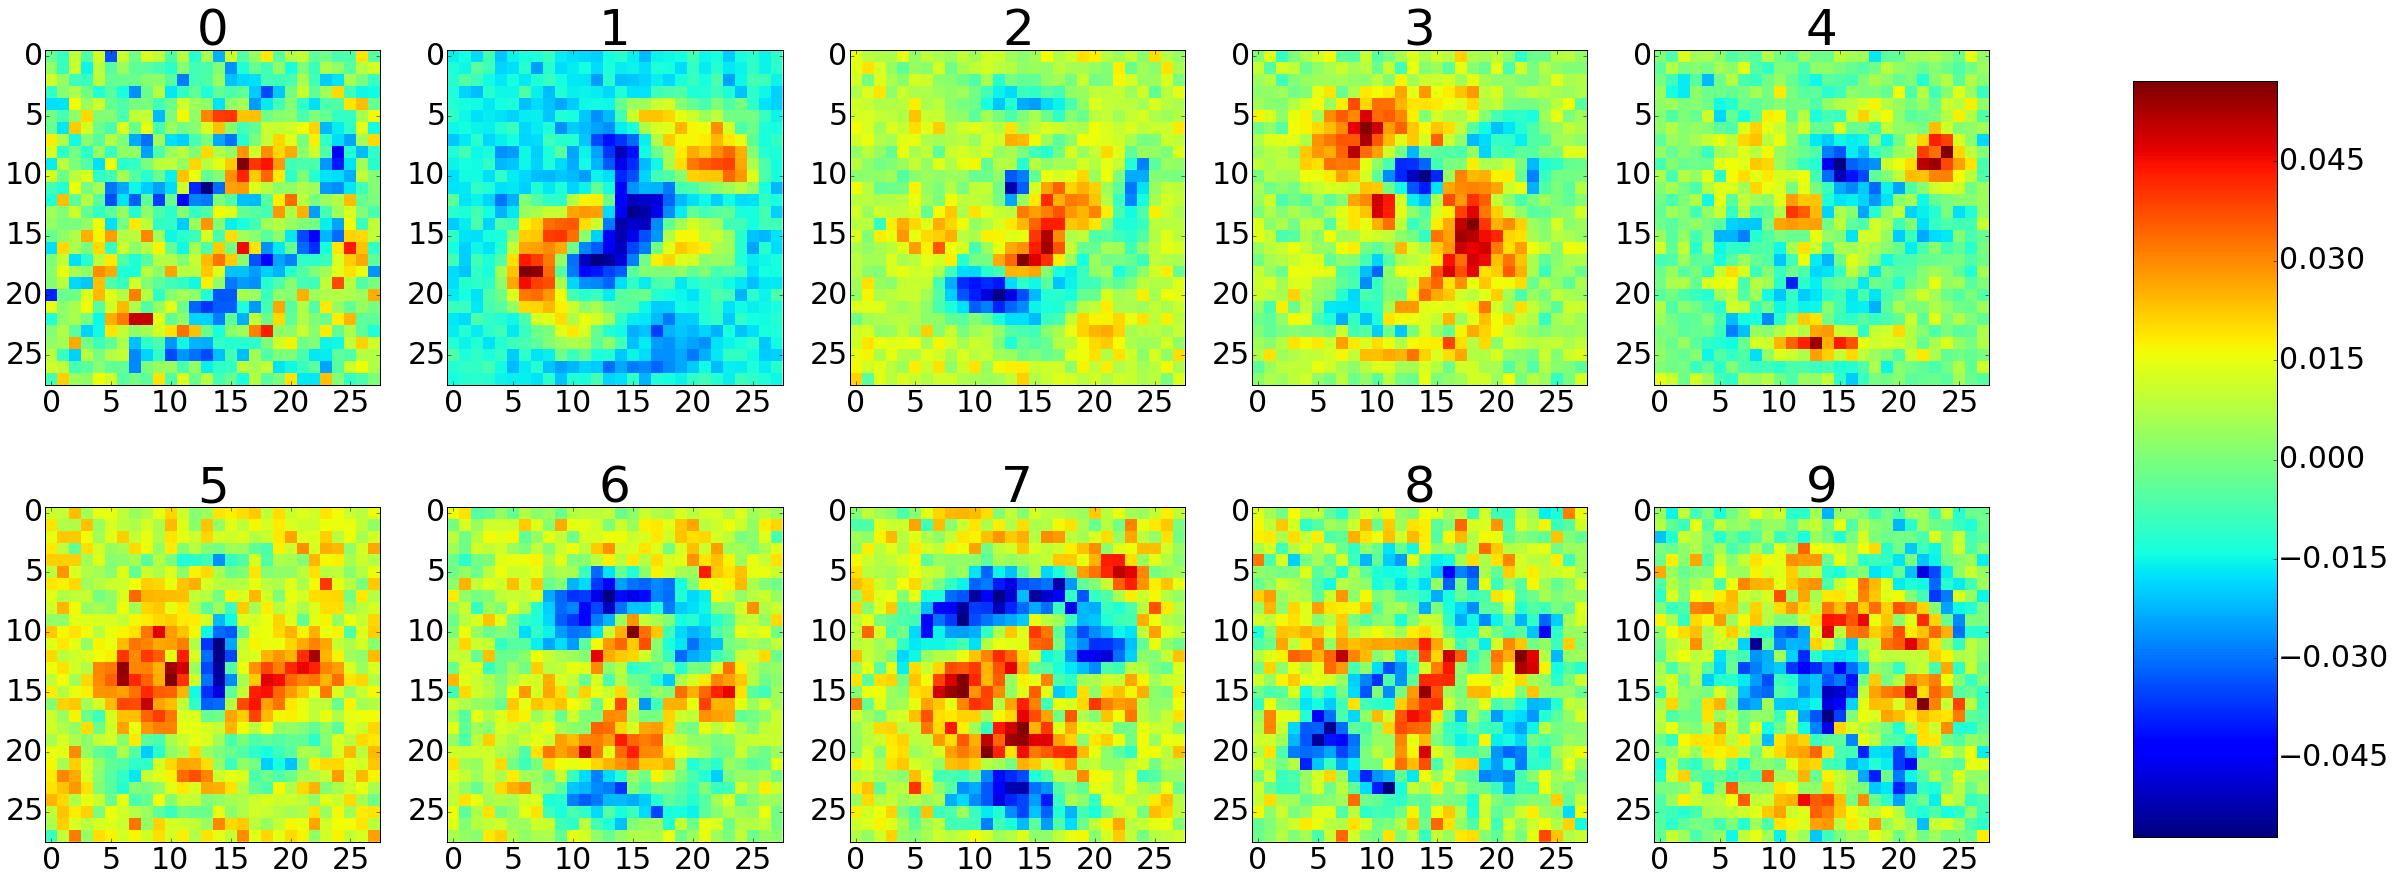

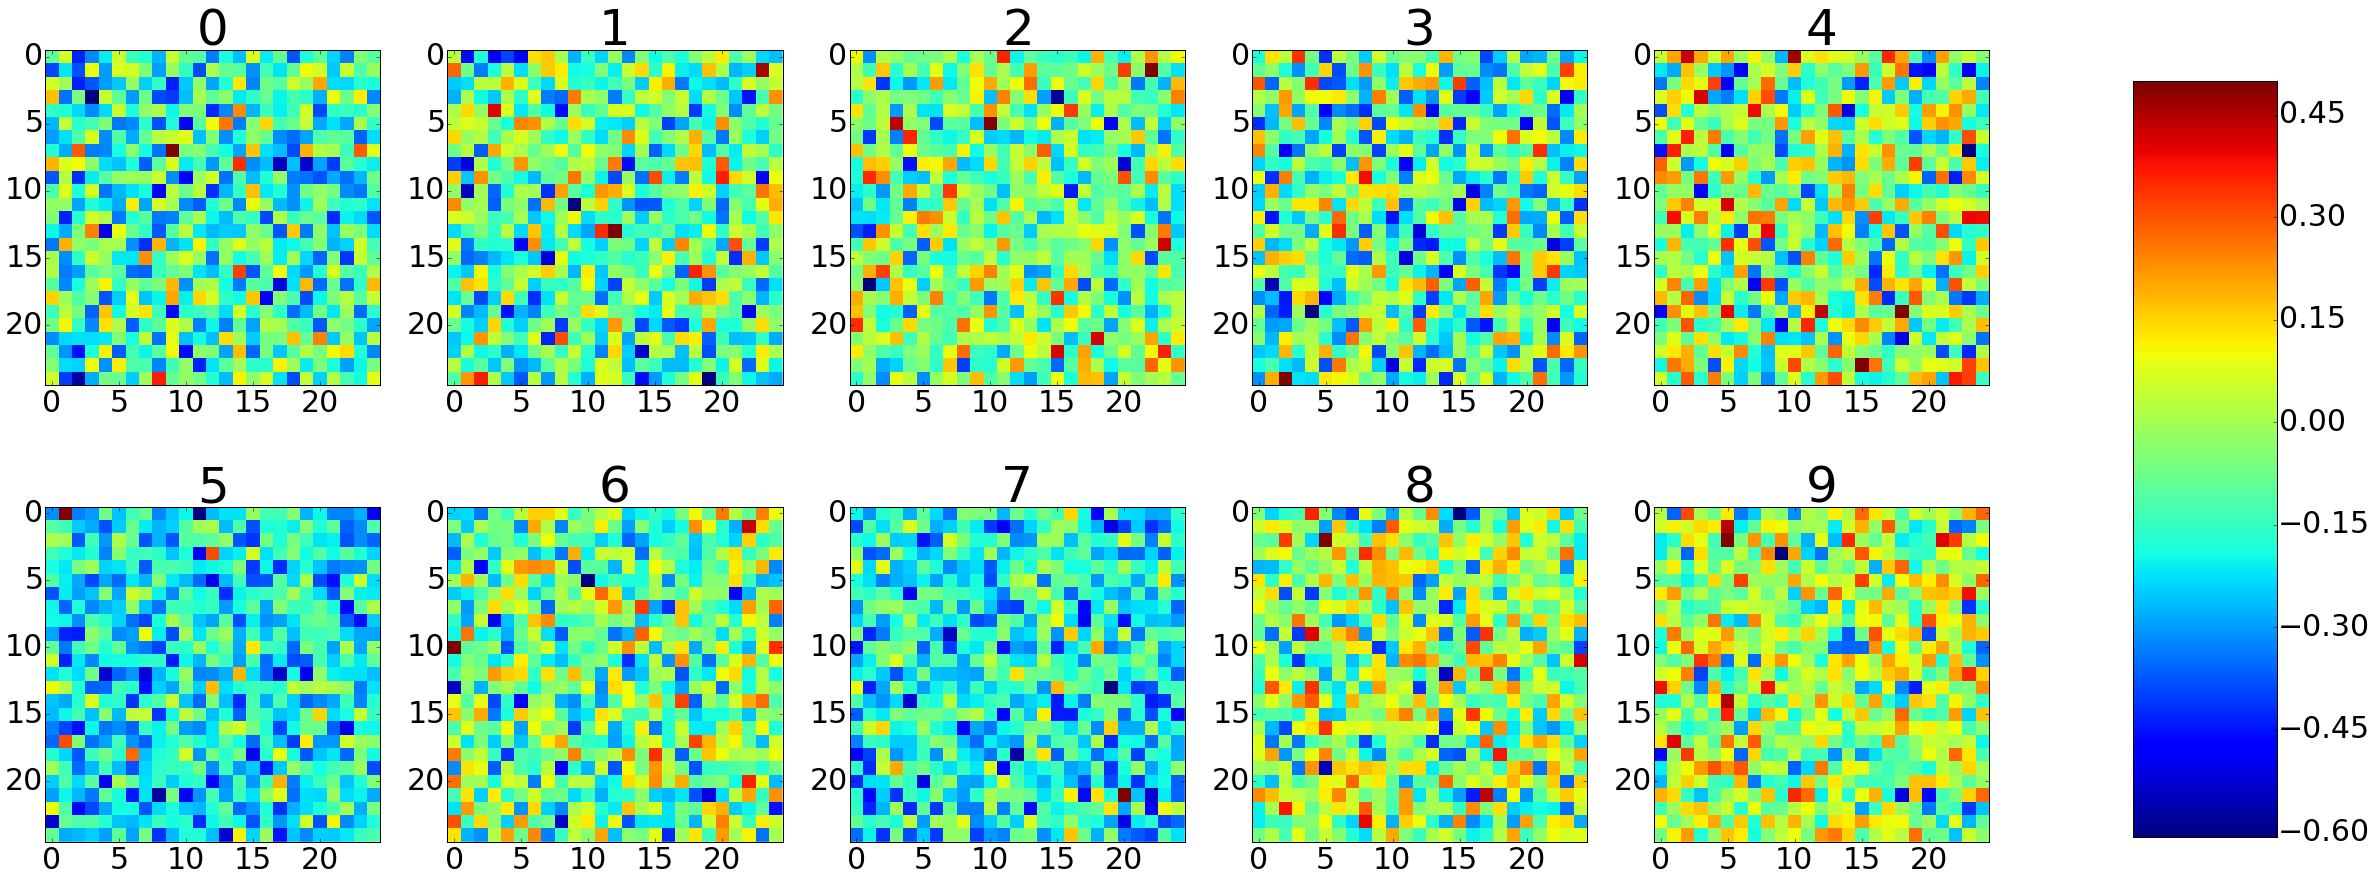

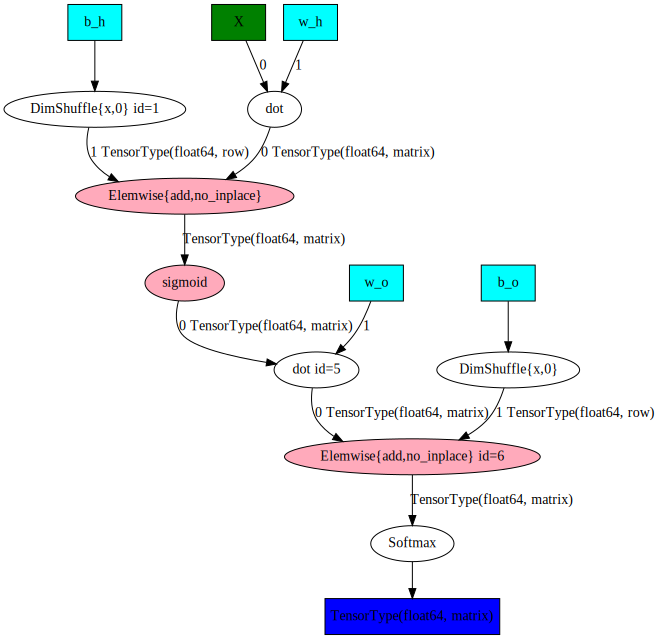

In [14]:
theano.printing.debugprint(py_x)
analyze_net(w_h, 28)
analyze_net(w_o, 25)
d3v.d3viz(predict, 'test-output/1HiddenLayer.html')
SVG(theano.printing.pydotprint(py_x, var_with_name_simple=True, return_image=True, format='svg'))

In [20]:
"""Modern feed forward net with 2 hiddden layers, fast update using RMSProp, 
ReLU activation function, and dropout to avoi overfitting. The architecture
as follow: 784 -> 625 -> 625 -> 10
"""
from theano.sandbox.rng_mrg import MRG_RandomStreams as RandomStreams
srng = RandomStreams()

def rectify(X):    
    return T.maximum(X, 0.)

def softmax(X):
    """numerically stable softmax"""
    e_x = T.exp(X - X.max(axis=1).dimshuffle(0, 'x'))
    return e_x / e_x.sum(axis=1).dimshuffle(0, 'x')

def RMSprop(cost, params, lr=0.001, rho=0.9, epsilon=1e-6):
    """scale the gradient"""
    grads = T.grad(cost=cost, wrt=params)
    updates = []
    for p, g in zip(params, grads):
        # a running average of the magnitude of the gradient
        
        # initialize acc to be zero in the same shape as p. It 
        # happens once in Python and not in compiled Theano function
        acc = theano.shared(p.get_value() * 0.) 
        
        # Each train execution of acc_new will use the current 
        # value of acc not its initial value.
        acc_new = rho * acc + (1 - rho) * g ** 2
        
        # scale the gradient based on runnning average
        gradient_scaling = T.sqrt(acc_new + epsilon)
        g = g / gradient_scaling
        
        # update weights and accummulator
        updates.append((acc, acc_new))
        updates.append((p, p - lr * g))
    return updates

def dropout(X, p=0.):    
    if p > 0:
        # randomly drop values and scale rest
        retain_prob = 1 - p
        X *= srng.binomial(X.shape, p=retain_prob, dtype=theano.config.floatX)
        X /= retain_prob
    return X

def model(X, w_h1, b_h1, w_h2, b_h2, w_o, b_o, p_drop_input, p_drop_hidden):
    X = dropout(X, p_drop_input)  # add some noise into network
    h1 = rectify(T.dot(X, w_h1) + b_h1)

    h1 = dropout(h1, p_drop_hidden)
    h2 = rectify(T.dot(h1, w_h2) + b_h2)

    h2 = dropout(h2, p_drop_hidden)
    py_x = softmax(T.dot(h2, w_o) + b_o)
    return h1, h2, py_x

In [21]:
X = T.fmatrix('X')
Y = T.fmatrix('Y')

w_h1 = init_weights((784, 625), 'w_h1')
b_h1 = init_bias(625, 'b_h1')
w_h2 = init_weights((625, 625), 'w_h2')
b_h2 = init_bias(625, 'b_h2')
w_o = init_weights((625, 10), 'w_o')
b_o = init_bias(10, 'b_o')

# add noise via dropout during training
noise_h1, noise_h2, noise_py_x = model(X, w_h1, b_h1, w_h2, b_h2, w_o, b_o, 0.2, 0.5)
# no noise during test time
h1, h2, py_x = model(X, w_h1, b_h1, w_h2, b_h2, w_o, b_o, 0., 0.)

y_x = T.argmax(py_x, axis=1)

cost = T.mean(T.nnet.categorical_crossentropy(noise_py_x, Y))
params = [w_h1, b_h1, w_h2, b_h2, w_o, b_o]
updates = RMSprop(cost, params, lr=0.001)

train = theano.function(inputs=[X, Y], outputs=cost, updates=updates, allow_input_downcast=True)
predict = theano.function(inputs=[X], outputs=y_x, allow_input_downcast=True)

for i in range(50):
    for start, end in zip(range(0, len(trX), 128), range(128, len(trX), 128)):
        cost = train(trX[start:end], trY[start:end])
    print i, np.mean(np.argmax(teY, axis=1) == predict(teX))

0 0.9388
1 0.9665
2 0.9733
3 0.976
4 0.9763
5 0.9779
6 0.9795
7 0.9794
8 0.9817
9 0.9817
10 0.9825
11 0.9833
12 0.9824
13 0.9839
14 0.9841
15 0.984
16 0.9835
17 0.9833
18 0.9841
19 0.9835
20 0.9839
21 0.9829
22 0.9845
23 0.9842
24 0.985
25 0.9841
26 0.9844
27 0.9859
28 0.9856
29 0.9853
30 0.9849
31 0.9857
32 0.9856
33 0.984
34 0.9863
35 0.9851
36 0.9856
37 0.9867
38 0.9867
39 0.9878
40 0.9864
41 0.9861
42 0.9858
43 0.9871
44 0.9857
45 0.9858
46 0.9858
47 0.9869
48 0.9866
49 0.9872


Elemwise{true_div,no_inplace} [id A] ''   
 |Elemwise{exp,no_inplace} [id B] ''   
 | |Elemwise{sub,no_inplace} [id C] ''   
 |   |Elemwise{add,no_inplace} [id D] ''   
 |   | |dot [id E] ''   
 |   | | |Elemwise{maximum,no_inplace} [id F] ''   
 |   | | | |Elemwise{add,no_inplace} [id G] ''   
 |   | | | | |dot [id H] ''   
 |   | | | | | |Elemwise{maximum,no_inplace} [id I] ''   
 |   | | | | | | |Elemwise{add,no_inplace} [id J] ''   
 |   | | | | | | | |dot [id K] ''   
 |   | | | | | | | | |X [id L]
 |   | | | | | | | | |w_h1 [id M]
 |   | | | | | | | |DimShuffle{x,0} [id N] ''   
 |   | | | | | | |   |b_h1 [id O]
 |   | | | | | | |DimShuffle{x,x} [id P] ''   
 |   | | | | | |   |TensorConstant{0.0} [id Q]
 |   | | | | | |w_h2 [id R]
 |   | | | | |DimShuffle{x,0} [id S] ''   
 |   | | | |   |b_h2 [id T]
 |   | | | |DimShuffle{x,x} [id U] ''   
 |   | | |   |TensorConstant{0.0} [id Q]
 |   | | |w_o [id V]
 |   | |DimShuffle{x,0} [id W] ''   
 |   |   |b_o [id X]
 |   |DimShuffle{0,x

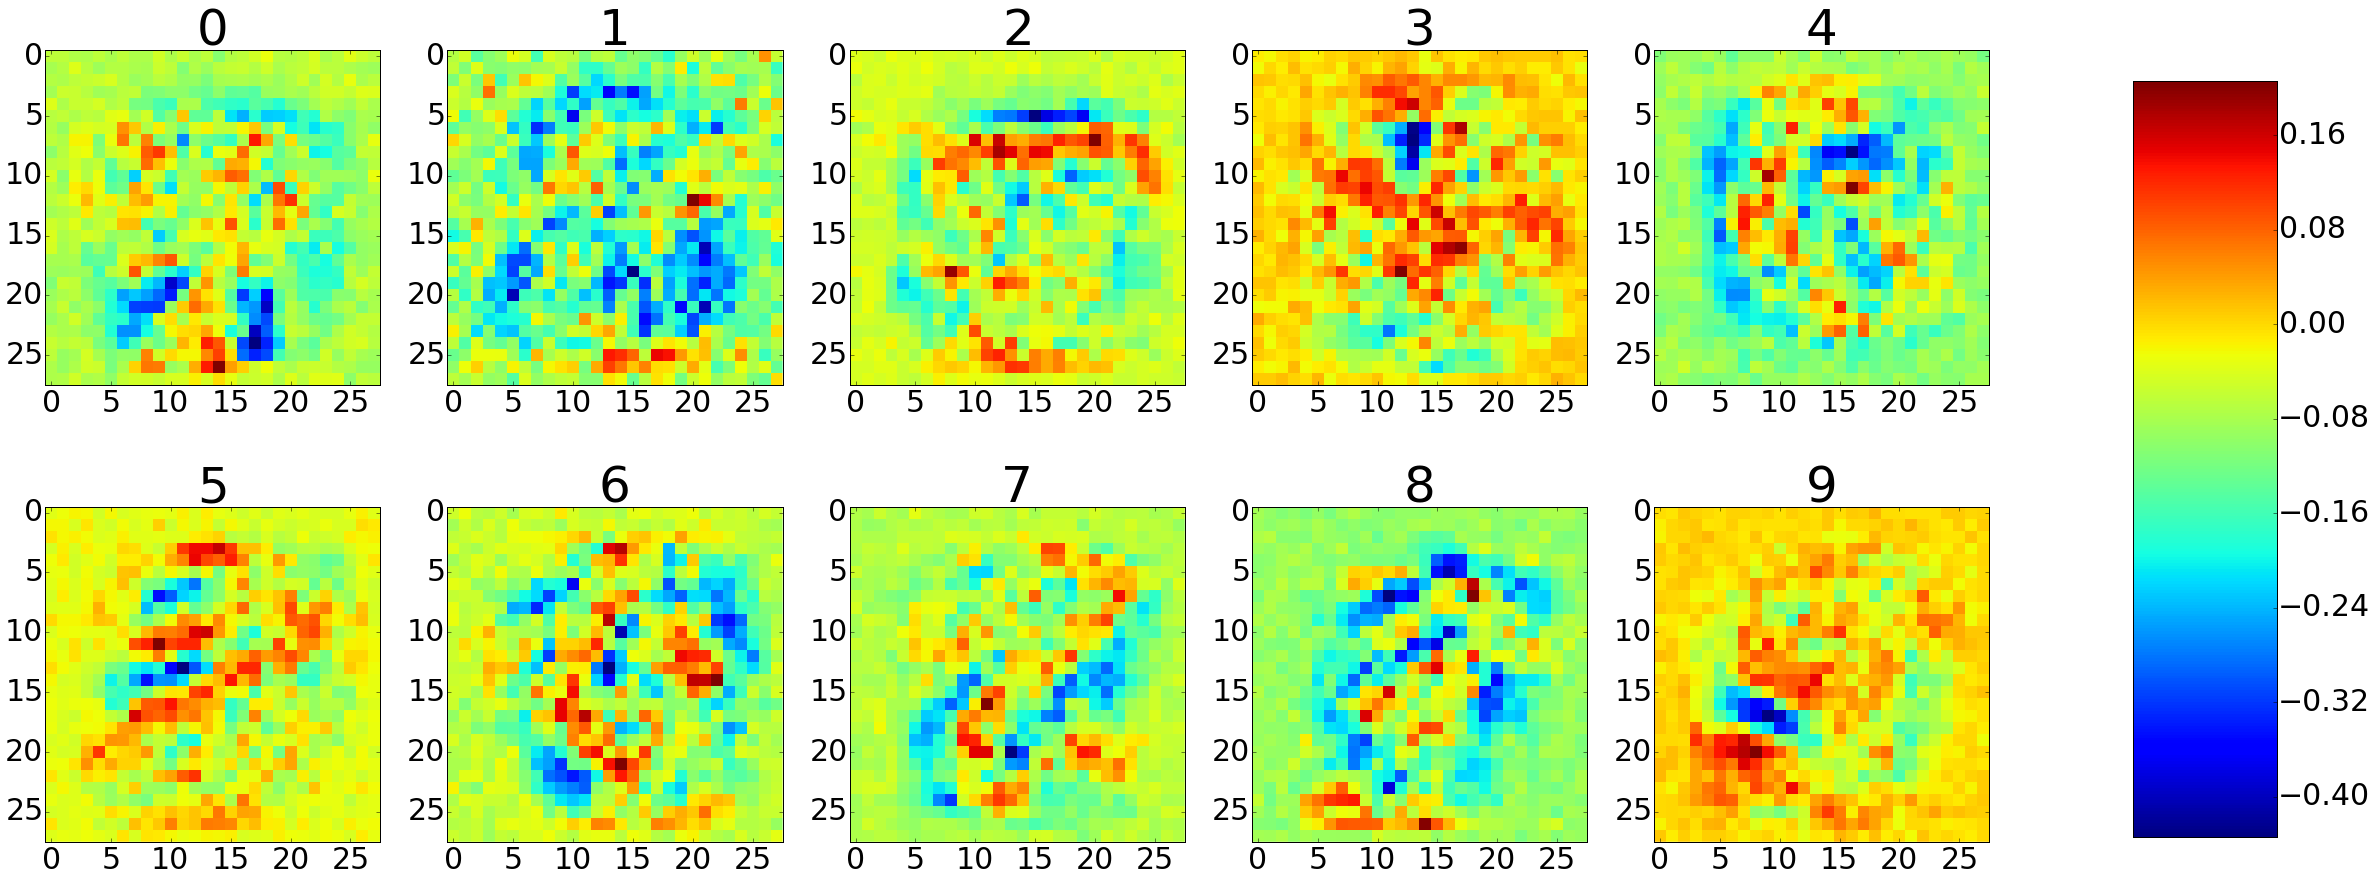

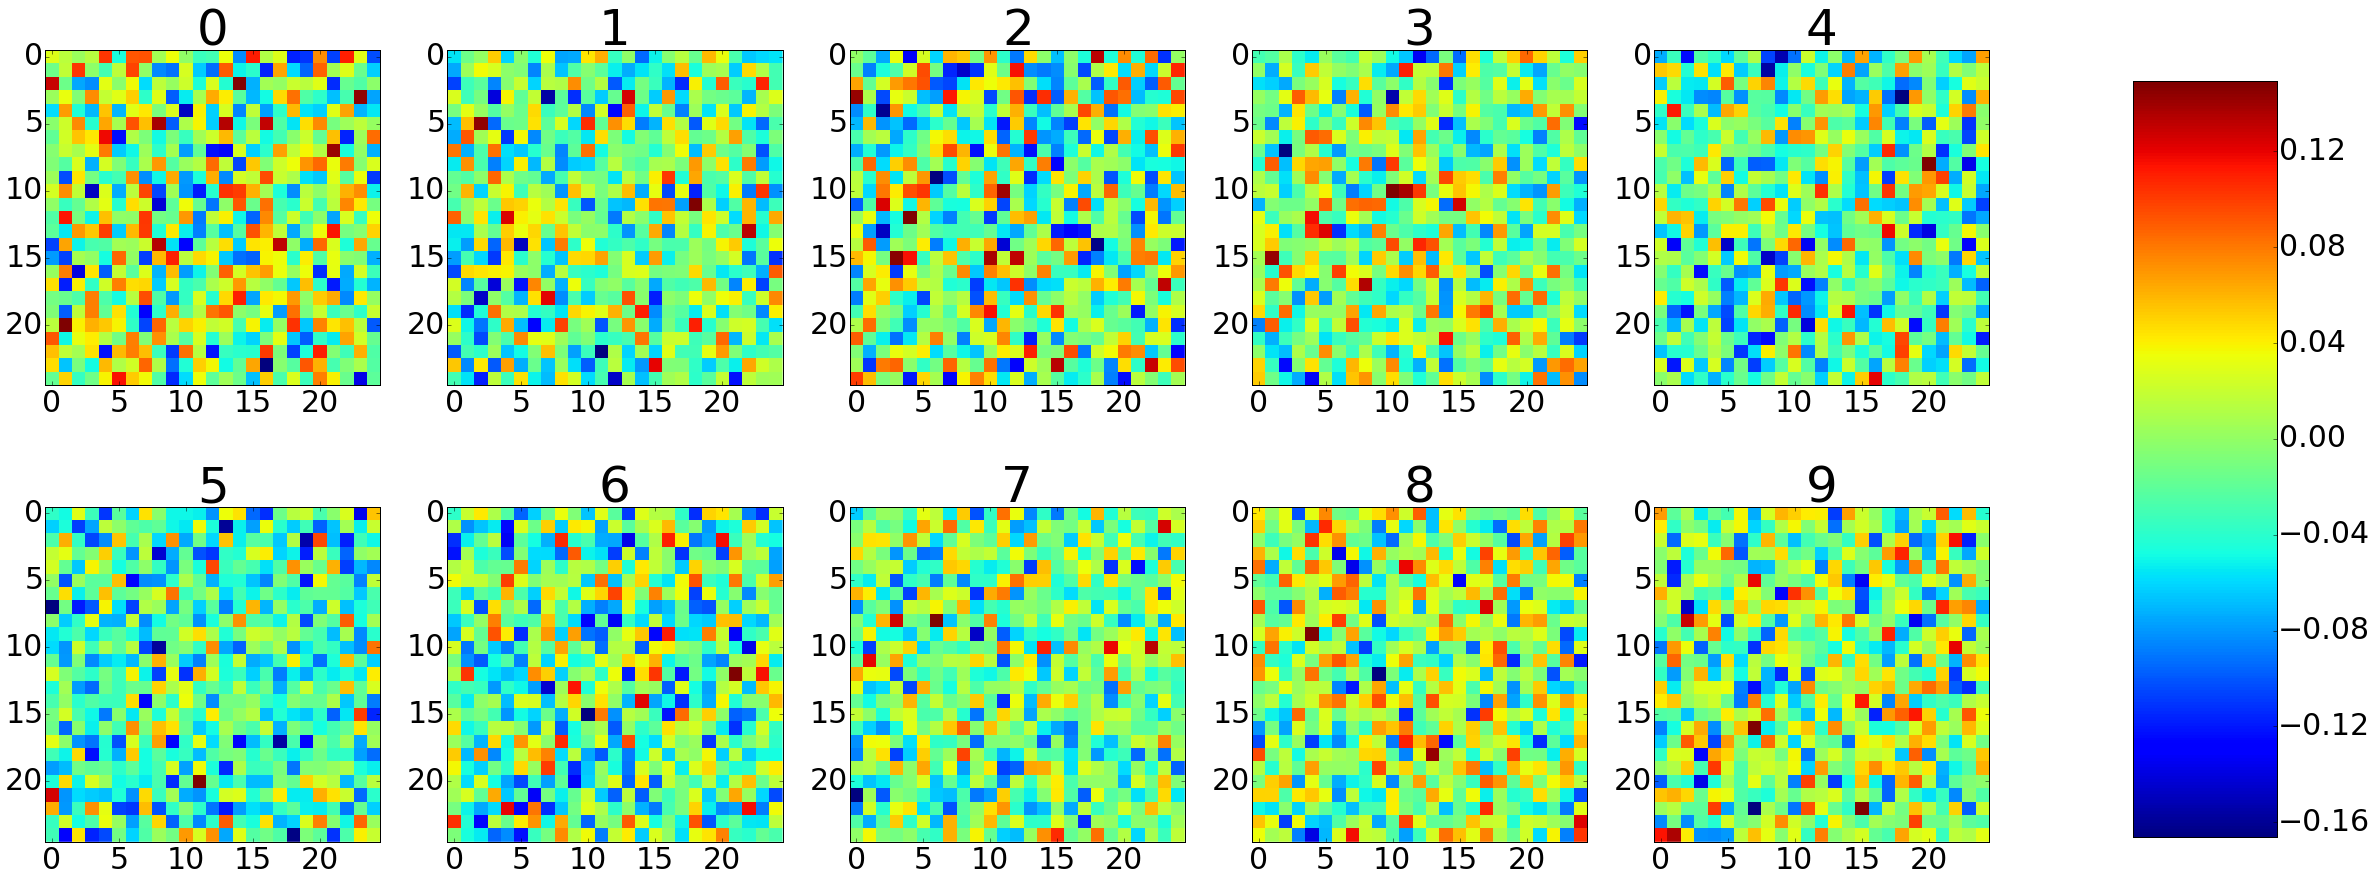

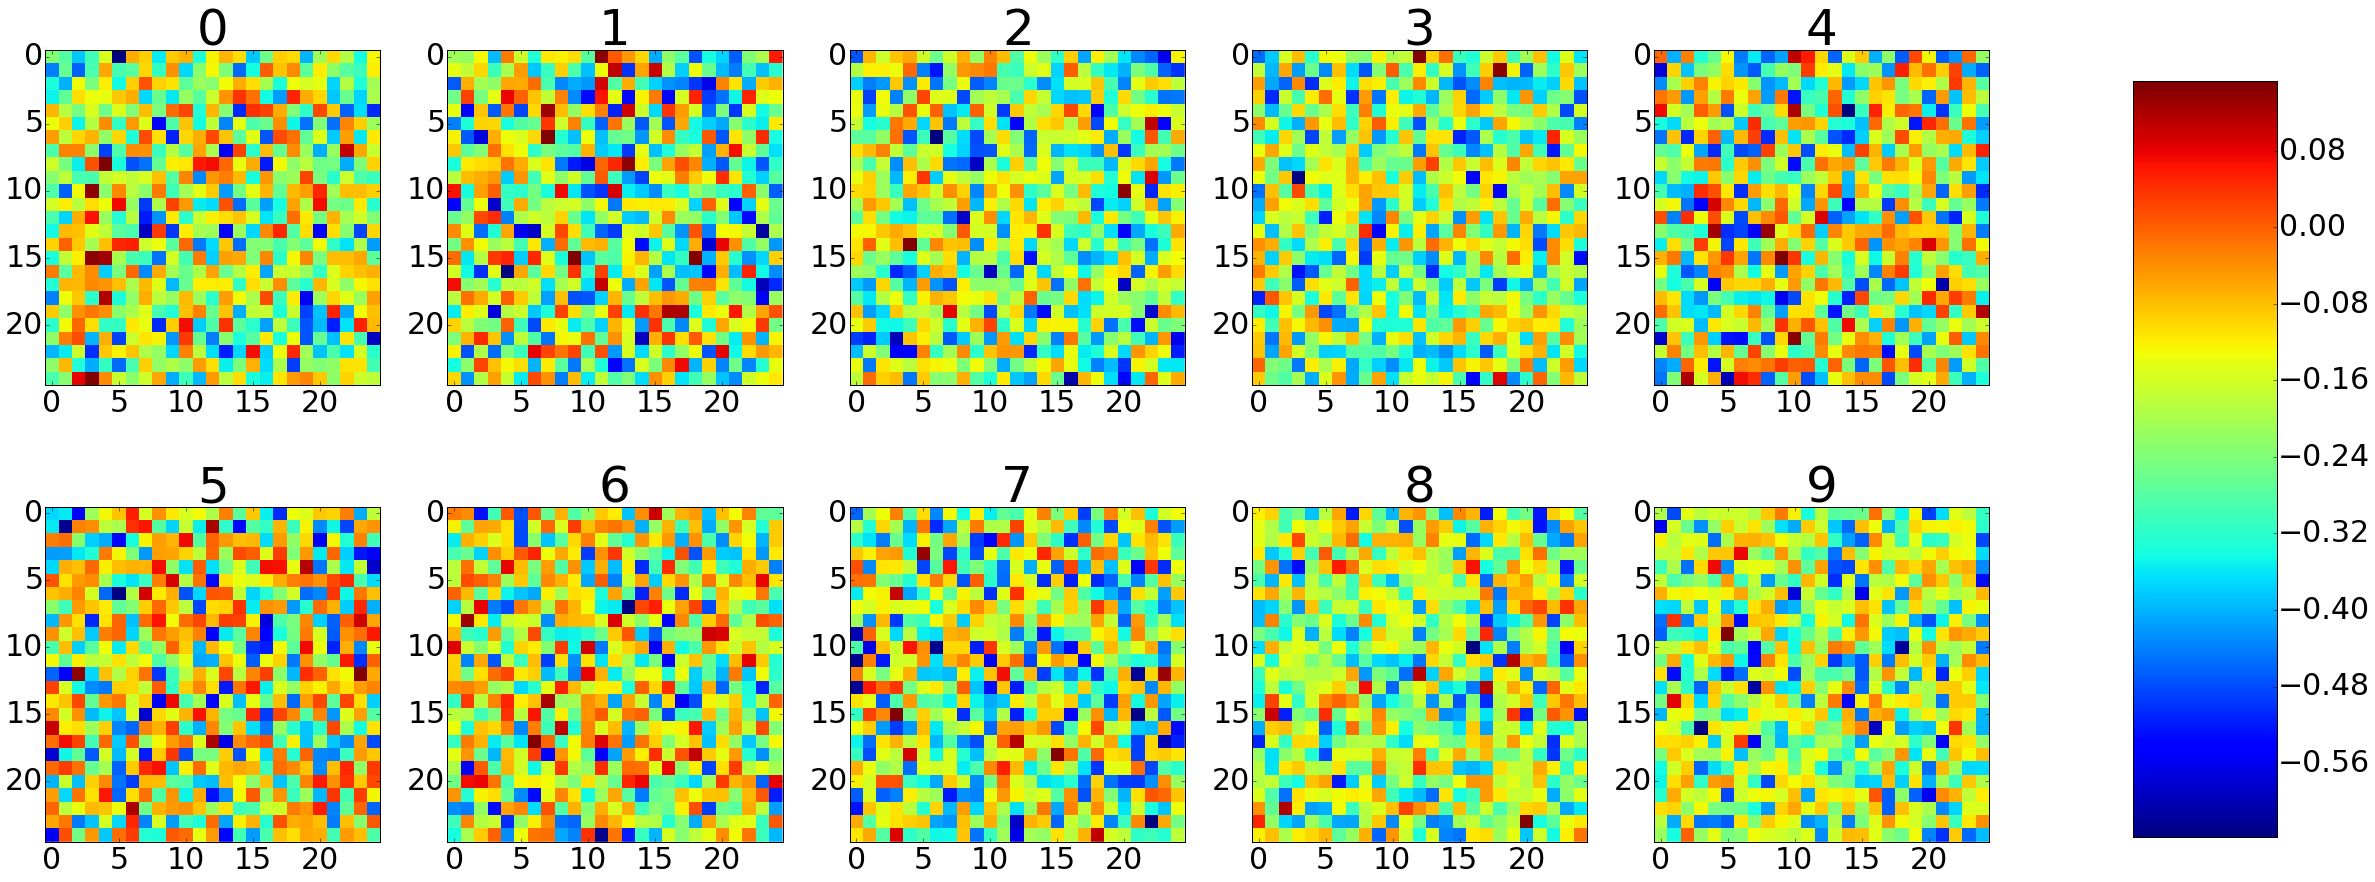

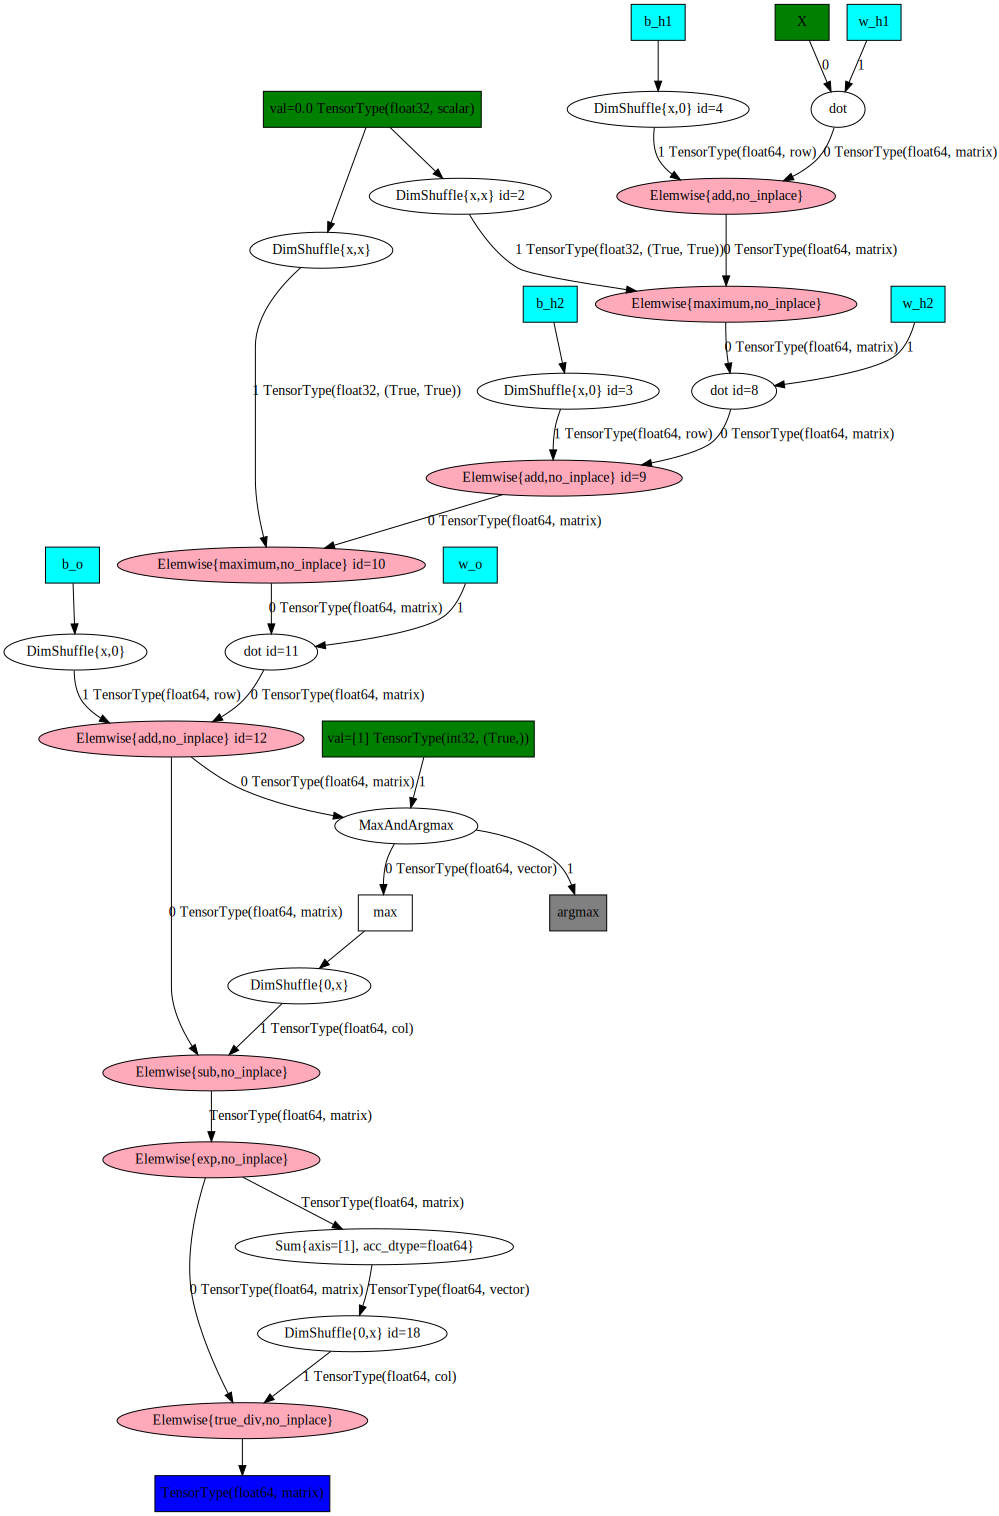

In [22]:
theano.printing.debugprint(py_x)
analyze_net(w_h1, 28)
analyze_net(w_h2, 25)
analyze_net(w_o, 25)
d3v.d3viz(predict, 'test-output/2HiddenLayer.html')
SVG(theano.printing.pydotprint(py_x, var_with_name_simple=True, return_image=True, format='svg'))

In [ ]:
"""Convolutional Neural Network"""
from theano.tensor.nnet.conv import conv2d
from theano.tensor.signal.downsample import max_pool_2d

def model(X, w, w2, w3, w4, p_drop_conv, p_drop_hidden):
    l1a = rectify(conv2d(X, w, border_mode='full'))
    l1 = max_pool_2d(l1a, (2, 2))
    l1 = dropout(l1, p_drop_conv)

    l2a = rectify(conv2d(l1, w2))
    l2 = max_pool_2d(l2a, (2, 2))
    l2 = dropout(l2, p_drop_conv)

    l3a = rectify(conv2d(l2, w3))
    l3b = max_pool_2d(l3a, (2, 2))
    l3 = T.flatten(l3b, outdim=2) # convert from tensor4 to normal matrix
    l3 = dropout(l3, p_drop_conv)

    l4 = rectify(T.dot(l3, w4))
    l4 = dropout(l4, p_drop_hidden)

    pyx = softmax(T.dot(l4, w_o))
    return l1, l2, l3, l4, pyx

trX, teX, trY, teY = mnist(onehot=True)

trX = trX.reshape(-1, 1, 28, 28) # reshape into conv tensor4(b, c, 0, 1) format
teX = teX.reshape(-1, 1, 28, 28)

X = T.dtensor4() # now tensor4 for convolutional instead of matrix
Y = T.fmatrix()

w = init_weights((32, 1, 3, 3)) # conv weights (n_kernels, n_channels, kernal_w, kernel_h)
w2 = init_weights((64, 32, 3, 3))
w3 = init_weights((128, 64, 3, 3))
w4 = init_weights((128 * 3 * 3, 625)) # highest conv layer has 128 filters and a 3x3 grid of responses
w_o = init_weights((625, 10))

noise_l1, noise_l2, noise_l3, noise_l4, noise_py_x = model(X, w, w2, w3, w4, 0.2, 0.5) # noise during training
l1, l2, l3, l4, py_x = model(X, w, w2, w3, w4, 0., 0.) # no noise for prediction
y_x = T.argmax(py_x, axis=1)

cost = T.mean(T.nnet.categorical_crossentropy(noise_py_x, Y))
params = [w, w2, w3, w4, w_o]
updates = RMSprop(cost, params, lr=0.001)

train = theano.function(inputs=[X, Y], outputs=cost, updates=updates, allow_input_downcast=True)
predict = theano.function(inputs=[X], outputs=y_x, allow_input_downcast=True)

for i in range(10):
    for start, end in zip(range(0, len(trX), 128), range(128, len(trX), 128)):
        cost = train(trX[start:end], trY[start:end])
    print np.mean(np.argmax(teY, axis=1) == predict(teX))

0.9283
0.9707
0.9827
0.9871
0.989
0.9898
0.9915
0.9925
0.9916
0.992


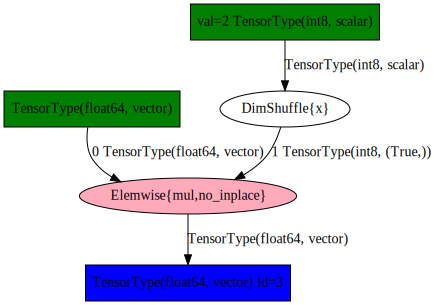

In [17]:
v = theano.tensor.vector()
from IPython.display import SVG
SVG(theano.printing.pydotprint(v*2, return_image=True, format='svg'))

In [ ]:
v = theano.tensor.vector()
from IPython.display import SVG
SVG(theano.printing.pydotprint(v*2, return_image=True, format='svg'))